# Taiwanese Bankruptcy Prediction
### Objective: Build a classification model capable of predicting which companies are going to go bankrupt to avoid bad investments.

## Importing the Dataset:

In [1]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd

taiwanese_bankruptcy_prediction = fetch_ucirepo(id=572) 

X = taiwanese_bankruptcy_prediction.data.features
y = taiwanese_bankruptcy_prediction.data.targets

df = pd.concat([X,y], axis = 1)

print(df.head())

    ROA(C) before interest and depreciation before interest  \
0                                           0.370594          
1                                           0.464291          
2                                           0.426071          
3                                           0.399844          
4                                           0.465022          

    ROA(A) before interest and % after tax  \
0                                 0.424389   
1                                 0.538214   
2                                 0.499019   
3                                 0.451265   
4                                 0.538432   

    ROA(B) before interest and depreciation after tax  \
0                                           0.405750    
1                                           0.516730    
2                                           0.472295    
3                                           0.457733    
4                                           0.522298    

 

## Scoping the Dataset:

In [2]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 1    ROA(A) before interest and % after tax                   6819 non-null   float64
 2    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 3    Operating Gross Margin                                   6819 non-null   float64
 4    Realized Sales Gross Margin                              6819 non-null   float64
 5    Operating Profit Rate                                    6819 non-null   float64
 6    Pre-tax net Interest Rate                                6819 non-null   float64
 7    After-tax net Interest Rate                              6819 non-null   float64
 8    Non-industry inco

#### Notes: 
- All features are continous apart from two integer columns which are flags and hence categorical features. I will need to use the describe method to confirm that they are binary, and what transformations they will need.
- There are no nulls picked up, reducing the need for any necessary data cleaning.

In [3]:
print(df.describe(include = 'int'))

        Liability-Assets Flag   Net Income Flag    Bankrupt?
count             6819.000000            6819.0  6819.000000
mean                 0.001173               1.0     0.032263
std                  0.034234               0.0     0.176710
min                  0.000000               1.0     0.000000
25%                  0.000000               1.0     0.000000
50%                  0.000000               1.0     0.000000
75%                  0.000000               1.0     0.000000
max                  1.000000               1.0     1.000000


#### Notes:

- To confirm, the flags are binary. However one of them is all '1', therefore this feature as it is unchanging can most likely be dropped.

In [4]:
df_null_check = df.isnull().sum()
df_null_check = df_null_check[df_null_check > 0]

print(df_null_check)

Series([], dtype: int64)


#### Notes: 
- No nulls confirmed.

In [5]:
print(df['Bankrupt?'].value_counts())

0    6599
1     220
Name: Bankrupt?, dtype: int64


#### Notes:
- The majority of the data set has '0' for it's target variable 'Bankruptcy'. Therefore, this dataset is heavily skewed and this will need considering if we are to build an effective model capable of achieving the objective and accurately predicting both classes. 

In [6]:
df_descr = df.describe().T
df_descr = df_descr[df_descr['max'] > 1]

print(df_descr)

                                         count          mean           std  \
 Operating Expense Rate                 6819.0  1.995347e+09  3.237684e+09   
 Research and development expense rate  6819.0  1.950427e+09  2.598292e+09   
 Interest-bearing debt interest rate    6819.0  1.644801e+07  1.082750e+08   
 Revenue Per Share (Yuan ¥)             6819.0  1.328641e+06  5.170709e+07   
 Total Asset Growth Rate                6819.0  5.508097e+09  2.897718e+09   
 Net Value Growth Rate                  6819.0  1.566212e+06  1.141594e+08   
 Current Ratio                          6819.0  4.032850e+05  3.330216e+07   
 Quick Ratio                            6819.0  8.376595e+06  2.446847e+08   
 Total debt/Total net worth             6819.0  4.416337e+06  1.684069e+08   
 Accounts Receivable Turnover           6819.0  1.278971e+07  2.782598e+08   
 Average Collection Days                6819.0  9.826221e+06  2.563589e+08   
 Inventory Turnover Rate (times)        6819.0  2.149106e+09  3.

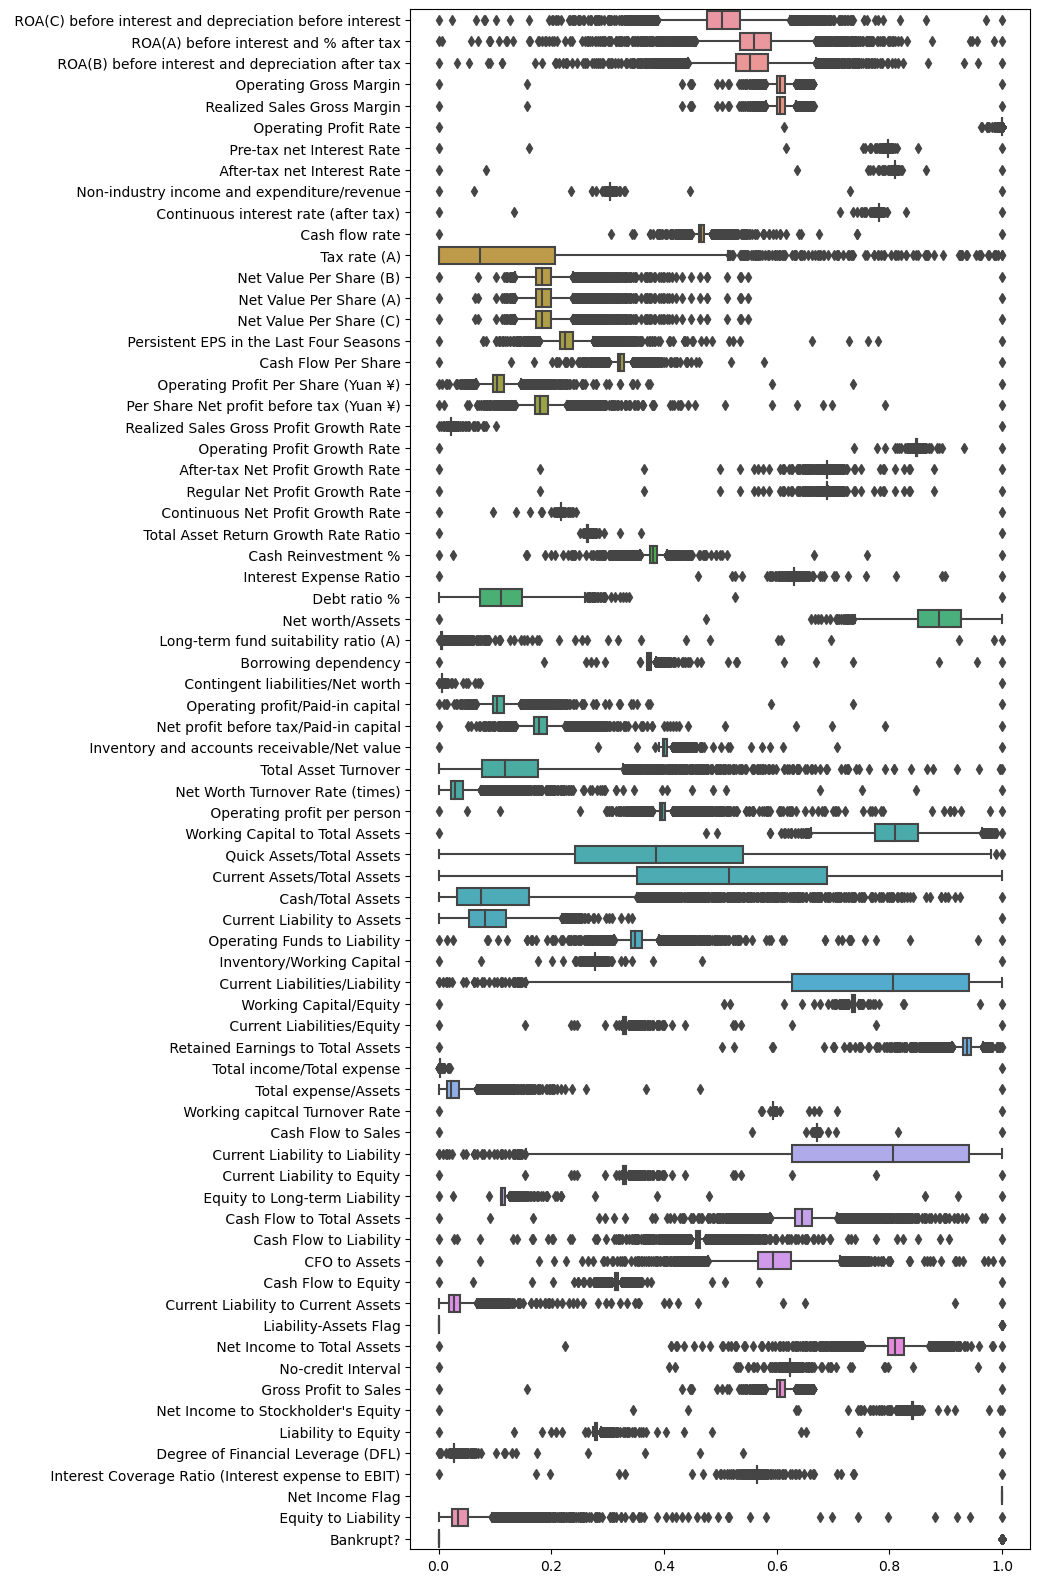

In [7]:
columns_toexclude = df_descr.index.tolist()

df_toboxplot = df.drop(columns = columns_toexclude)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 20))
sns.boxplot(orient = 'h', data = df_toboxplot)
plt.show()

#### Notes: 
- 24 of the continuous features have max values that are surplus to 1.
- The rest of the features are already between 0 and 1.
- Meaning only 24 will require a standard scaler, the other will be left as they are currently.

### Final Data Scoping Notes

- There is little data cleaning to do as all the features are populated.
- However, due to the large number of features and the fact some features are closely related, we may be able in a later version to reduce the complexity via reducing the features that are unnecessary.
- As almost all the features are continious we will be employing standard scaler, but only for the 24 features whose values are not already between 0 and 1.
- The 2 categorical features are already encoded as 0/1, the column ['Net Income Flag'] however is a uniform value and hence this can be dropped.
- We will need to accomodate for the imbalanced dateset, by adjusting class weights.

## Data Cleaning:

In [8]:
df.drop(columns = ' Net Income Flag', inplace = True)  

#### Notes:

- Unnecessary column dropped.

## Data Exploration:

In [9]:
target_corr = df.corr()['Bankrupt?'].sort_values(key=abs, ascending=False)
                          
print(target_corr[0:10])

Bankrupt?                                                   1.000000
 Net Income to Total Assets                                -0.315457
 ROA(A) before interest and % after tax                    -0.282941
 ROA(B) before interest and depreciation after tax         -0.273051
 ROA(C) before interest and depreciation before interest   -0.260807
 Net worth/Assets                                          -0.250161
 Debt ratio %                                               0.250161
 Persistent EPS in the Last Four Seasons                   -0.219560
 Retained Earnings to Total Assets                         -0.217779
 Net profit before tax/Paid-in capital                     -0.207857
Name: Bankrupt?, dtype: float64


#### Notes:

- The above highlights the top strongest 10 correlated values with the target variable 'Bankrupt?'.
- As the vast number of features has been reduced down, I can now explore further with a pairplot.
- However, I will drop 2 of the ROA columns as they are similar metrics. Likewise for Net Worth/Assets and Debt Ratio.

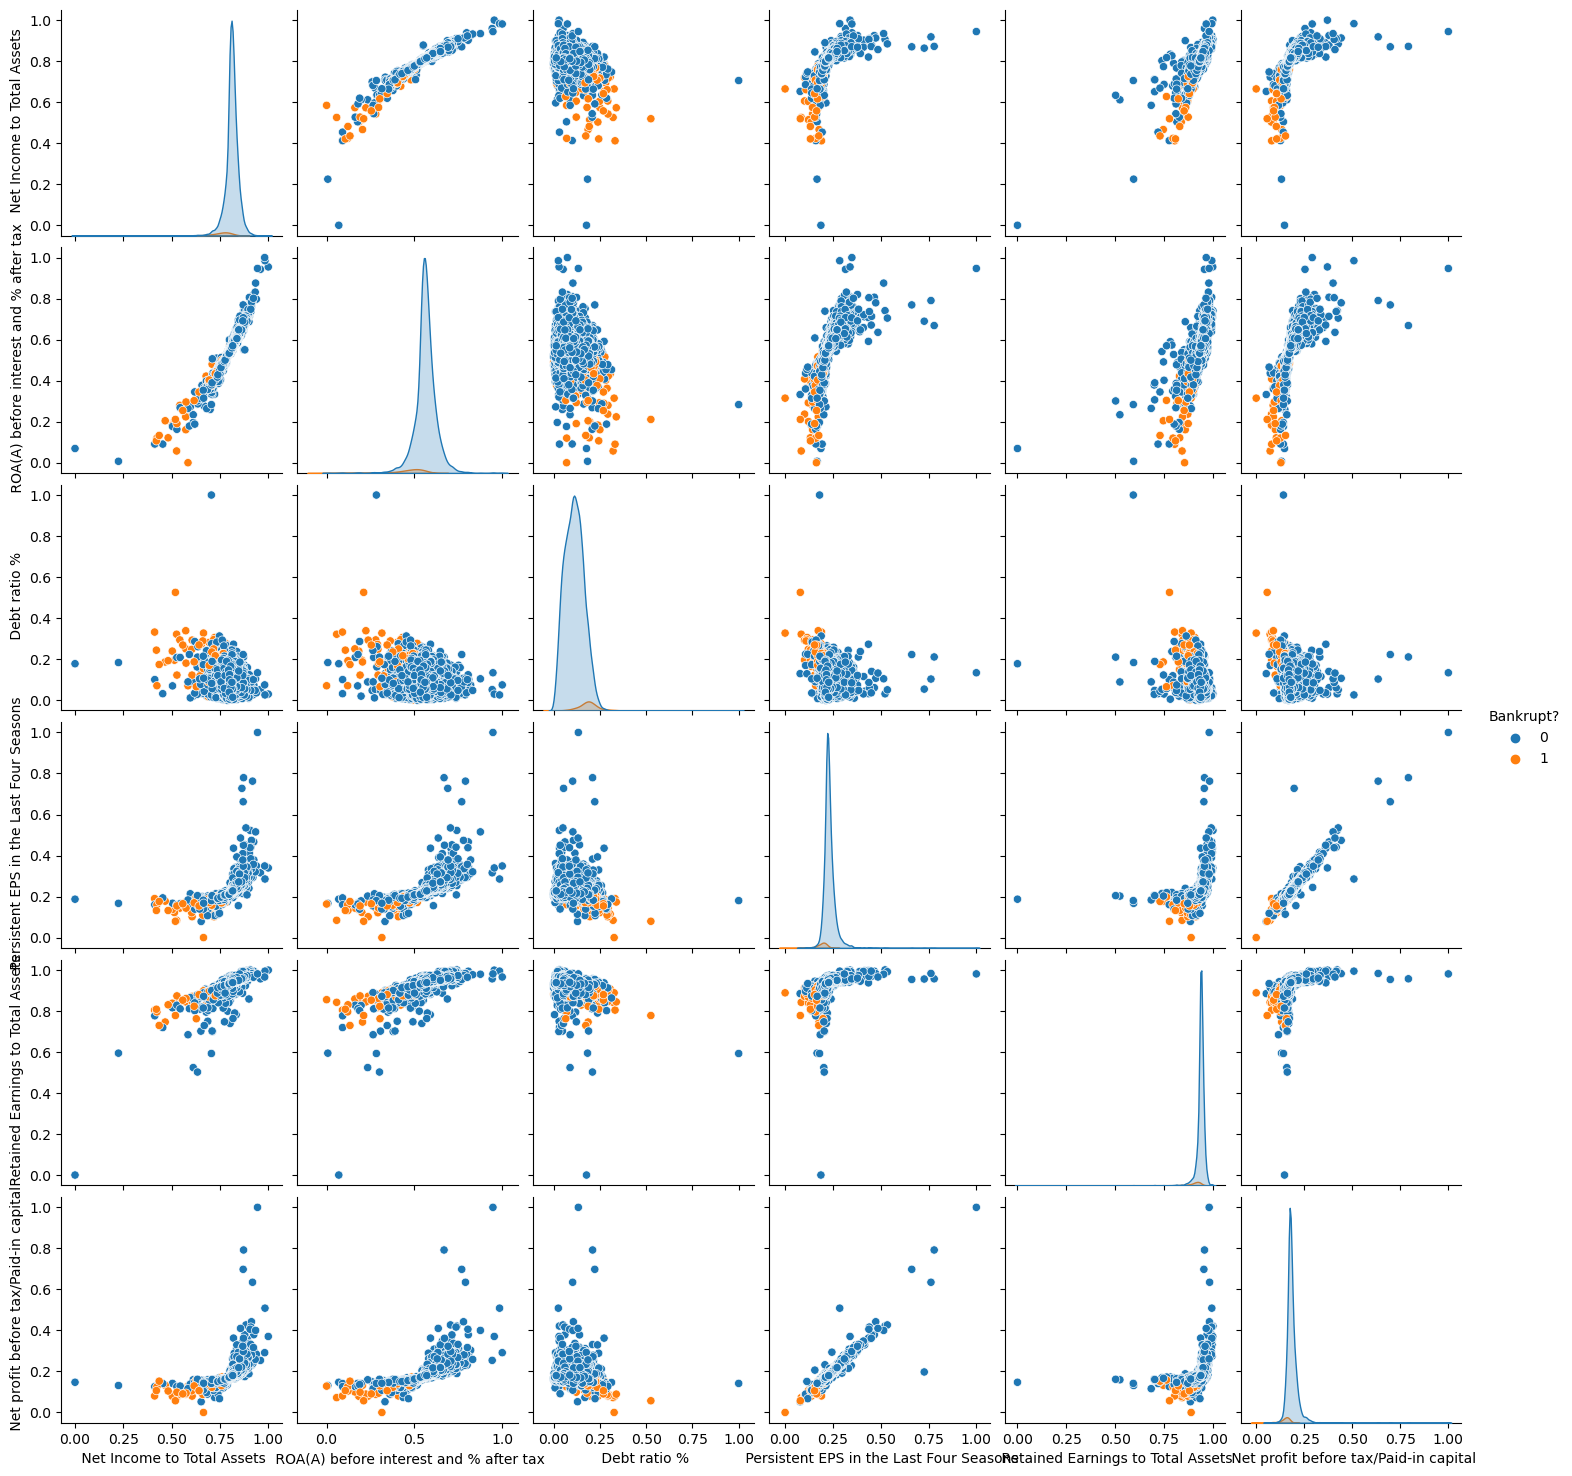

In [10]:
import numpy as np

#key_features = target_corr[0:10].index.tolist()

top3_corr = target_corr[0:3].index.tolist() # top 3 features including the target variable
other_corr = target_corr[6:10].index.tolist() # other key features

key_features_list = top3_corr + other_corr

# print(key_features_list)



sns.pairplot(df[key_features_list], hue = 'Bankrupt?')
plt.show()

#### Notes:

- From the above pairplot we can see that for the most correlated features next to the target variable, they often cluster together.
- These clusters, indicate that building a predictive model will be possible. In domain terms, if a company is displaying such features they would be at much higher risk at bankruptcy.
- On the contrary, there are some outliers where the companies did not go bankrupt despite exhibiting similar or if not worse features than the bankrupt cases. This may be something to consider and possible deal with if the first iteration of the model does not perform with as much effectiveness as desired.
- Some of the more clearly cut pairwise clusters are 'Net Income to Total Assets' vs 'Net Profit before Tax', 'ROA before Interest and % after tax' vs 'Persistant EPS in the lasts 4 seasons', and 'Debt Ratio vs 'ROA before Interest and % after tax'. Therefore, we can expect these features to show up when evaluating feature importances later in the model.

## Data Preprocessing:

In [11]:
X_unscaled = df.drop(columns = 'Bankrupt?')
X_toScale = X_unscaled[columns_toexclude] # From the previous stages where the features with a range outside 0-1 were defined.
X_noScale = X_unscaled.drop(columns = columns_toexclude)
y = df['Bankrupt?']

print(f'Features that will be scaled: {X_toScale.columns}')
print(f'Features that will not be scaled: {X_noScale.columns}')

Features that will be scaled: Index([' Operating Expense Rate', ' Research and development expense rate',
       ' Interest-bearing debt interest rate', ' Revenue Per Share (Yuan ¥)',
       ' Total Asset Growth Rate', ' Net Value Growth Rate', ' Current Ratio',
       ' Quick Ratio', ' Total debt/Total net worth',
       ' Accounts Receivable Turnover', ' Average Collection Days',
       ' Inventory Turnover Rate (times)', ' Fixed Assets Turnover Frequency',
       ' Revenue per person', ' Allocation rate per person',
       ' Quick Assets/Current Liability', ' Cash/Current Liability',
       ' Inventory/Current Liability',
       ' Long-term Liability to Current Assets',
       ' Current Asset Turnover Rate', ' Quick Asset Turnover Rate',
       ' Cash Turnover Rate', ' Fixed Assets to Assets',
       ' Total assets to GNP price'],
      dtype='object')
Features that will not be scaled: Index([' ROA(C) before interest and depreciation before interest',
       ' ROA(A) before interest

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X_toScale)
X_scaled = pd.DataFrame(data = X_scaled, columns = X_toScale.columns)

print(X_scaled.head())

    Operating Expense Rate   Research and development expense rate  \
0                -0.616334                               -0.750713   
1                -0.616334                               -0.750713   
2                -0.616334                               -0.740898   
3                -0.616334                               -0.750713   
4                 1.820772                               -0.750713   

    Interest-bearing debt interest rate   Revenue Per Share (Yuan ¥)  \
0                             -0.151921                    -0.025697   
1                             -0.151921                    -0.025697   
2                             -0.151921                    -0.025697   
3                             -0.151921                    -0.025697   
4                             -0.151921                    -0.025697   

    Total Asset Growth Rate   Net Value Growth Rate   Current Ratio  \
0                 -0.182259               -0.013721       -0.012111   
1   

In [13]:
X = pd.concat([X_noScale, X_scaled], axis = 1)

## print(X.head())

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

print(f'Train Size: {len(X_train)}')
print(f'Test Size: {len(y_test)}')

Train Size: 5455
Test Size: 1364


## Model Development:

In [15]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


### Baseline Accuracy with a Dummy Classifier:

In [26]:
class_zero = df[df['Bankrupt?'] == 0]

baseline_accur = len(class_zero)/len(df)
                                        
print(f'Accuracy if predicting based on the most frequent class: {baseline_accur:.4f} ')

Accuracy if predicting based on the most frequent class: 0.9677 


#### Notes:

- Taking the most frequent class, the baseline classifier accuracy would be 96.7%.

### Model without SMOTE:

In [17]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xg = XGBClassifier(random_state = 42) 

xg.fit(X_train, y_train)

y_pred = xg.predict(X_test)

score = accuracy_score(y_pred, y_test)

print(f'XG Score: {score:.4f}')

XG Score: 0.9743


#### Notes:

- An accuracy score of 97.4% is exceptionally high and based off this metric alone it shows this model is capable of achieving the objective.
- However, it is only an improvement of 0.7% to the dummy classifier. Despite the heavily skewed dataset leading to not much room for improvement, this is not the number we would hope for to deploy an effective model.

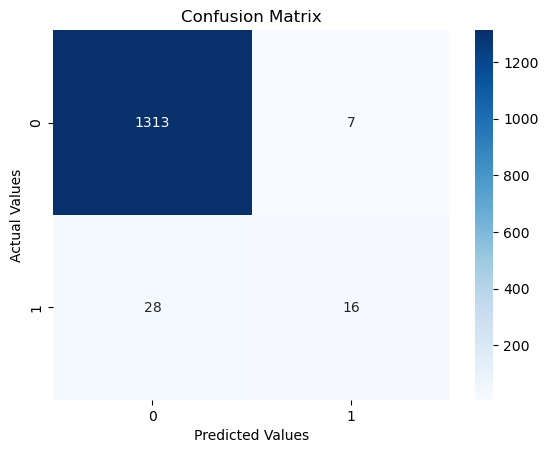

In [18]:
from sklearn.metrics import confusion_matrix

conf_matr = confusion_matrix(y_test, y_pred)

sns.heatmap(data = conf_matr, annot = True, cmap = 'Blues', fmt = 'd')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

#### Notes:

- The model predicts cases that won't go bankrupt extremely well (1300 correct to 20 incorrect), it struggles severely on classing cases that will go bankrupt (16 correct, 28 incorrect).

In [27]:
from sklearn.metrics import classification_report

xg_class_report = classification_report(y_test, y_pred)

print(xg_class_report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1320
           1       0.70      0.36      0.48        44

    accuracy                           0.97      1364
   macro avg       0.84      0.68      0.73      1364
weighted avg       0.97      0.97      0.97      1364



#### Notes:

- The classification report further demonstrates the points of the confusion matrix, with an exceptionally high f1 score of 0.99 for the majority class.
- However, it's the minority class (cases going bankrupt) which in the business context matters most. With a recall of just 0.36, this is dangerously low. 
- In context, this would mean the business would lose money investing into companies that are predicted safe, but are in fact going bankrupt.

## Attempting a remodel with SMOTE:

In [19]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(y_train.value_counts())
print(y_train_smote.value_counts())

0    5279
1     176
Name: Bankrupt?, dtype: int64
0    5279
1    5279
Name: Bankrupt?, dtype: int64


In [20]:
xg_smote = XGBClassifier(random_state = 42) #scale_pos_weight = scale_pos_weight

xg_smote.fit(X_train_smote, y_train_smote)

y_pred_smote = xg_smote.predict(X_test)

score_smote = accuracy_score(y_pred_smote, y_test)

print(f'XG Score with Smote Sample: {score_smote:.4f}')

XG Score with Smote Sample: 0.9611


#### Notes:

- The accuracy of the model using SMOTE falls in comparison to the previous, and even performs worse than the dummy classifier at 96.1%.

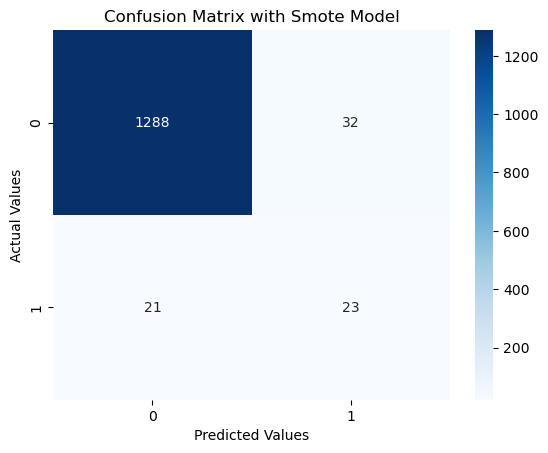

In [21]:
conf_matr_smote = confusion_matrix(y_test, y_pred_smote)

sns.heatmap(data = conf_matr_smote, annot = True, fmt = 'd', cmap = 'Blues')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.title('Confusion Matrix with Smote Model')
plt.show()

#### Notes:

- The confusion matrix for the model using SMOTE shows that compared to the previous, it performs worse on the majority class (1288 correct to 32 incorrect), but performs better on the minority class (23 correct, 21 incorrect).

In [48]:
from sklearn.metrics import classification_report

class_report = classification_report(y_test, y_pred_smote)

print(class_report)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1320
           1       0.42      0.52      0.46        44

    accuracy                           0.96      1364
   macro avg       0.70      0.75      0.72      1364
weighted avg       0.97      0.96      0.96      1364



#### Notes:

- The classification report for the model using SMOTE confirms that the recall for the minority class has improved from 0.36 to 0.52. 
- Although it's not a significantly high, this is the most important metric in regards to the business. Thus, in order to avoid bad investments the model using smote would be more applicable than the previous.

#### Model Development Final Notes:

- Overall, the model does not yet show considerable potential in adding value to the business context. 
- Despite a lower accuracy than even the dummy classifier, I will proceed with the model using SMOTE.
- The reasoning being that in terms of the business, our aim is to avoid bad investments and not invest in companies which are going bankrupt, losing the business money.
- Thus with a higher recall for the bankrupt class of 0.52 vs 0.36, this would add more value in terms of our objective.
- The next stage will be to use decision thresholds to find a threshold in which we can automate decision making of investments, but for this both classes will have to perform to an exceptionally high accuracy. 
- The cases which cases which do not match the confidence threshold, will be left to manually be worked.
- Final decision on deployment is still pending.

## Decision Threshold:

In [31]:
## Returns probabality of each case for each class.
xg_smote_probability = xg_smote.predict_proba(X_test)

## Returns the max probablity for each case
xg_smote_max_prob = np.max(xg_smote_probability, axis = 1)

## Returns the class (indices) with the max probablity for each case
xg_smote_class_prob = np.argmax(xg_smote_probability, axis = 1)

print(xg_smote_probability[0:10])
print(xg_smote_max_prob[0:10])
print(xg_smote_class_prob[0:10])

[[9.9997818e-01 2.1839996e-05]
 [9.9896663e-01 1.0333710e-03]
 [9.9999368e-01 6.2999102e-06]
 [9.9989355e-01 1.0643202e-04]
 [9.9722570e-01 2.7742959e-03]
 [5.8621895e-01 4.1378102e-01]
 [9.7912991e-01 2.0870106e-02]
 [9.6315694e-01 3.6843061e-02]
 [9.9997818e-01 2.1809026e-05]
 [9.8489863e-01 1.5101402e-02]]
[0.9999782  0.99896663 0.9999937  0.99989355 0.9972257  0.58621895
 0.9791299  0.96315694 0.9999782  0.9848986 ]
[0 0 0 0 0 0 0 0 0 0]


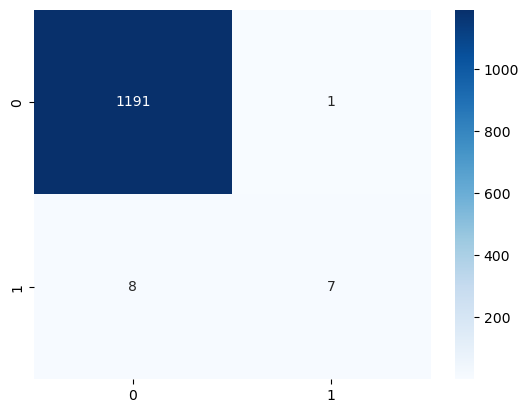

In [41]:
## Setting the Decision Threshold
decision_threshold = 0.99

## Returning the indices of the classes where the probability is greater than the threshold.
confident_indices = xg_smote_max_prob > decision_threshold

## Filtering y test to only confident cases.
confident_ytest = y_test[confident_indices]

## Filtering y pred to only confident cases.
confident_ypred = xg_smote_class_prob[confident_indices]

## Confusion Matrix for the cases that pass the threshold
confident_conf_matr = confusion_matrix(confident_ytest, confident_ypred)

sns.heatmap(data = confident_conf_matr, annot = True, fmt = 'd', cmap = 'Blues')
plt.show()


In [42]:
confident_class_report = classification_report(confident_ytest, confident_ypred)

print(confident_class_report)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1192
           1       0.88      0.47      0.61        15

    accuracy                           0.99      1207
   macro avg       0.93      0.73      0.80      1207
weighted avg       0.99      0.99      0.99      1207



#### Notes:

- As displayed by the above, by setting the decision threshold to 0.99 we can almost perfectly predict if a business is not going to go bankrupt (1,191 correct to 1 incorrect, f1 score = 1).
- However despite the decision threshold the f1 score has not improved for the positive class (cases going bankrupt) with an f1 score of 0.61 and a recall of 0.47.
- Thus, I am going to reframe the business objective from
    - Previous = Be able to predict business to avoid investing into.
    - New = Be able to predict business it is safe to invest into.
- This will still save resources and reduce the work of thorough checks onto businesses which are safe. Thus improving efficiency and still having a business gain.